In [1]:
import torch

In [2]:
if torch.cuda.is_available():
    print("CUDA is available!")
else:
    print("CUDA is not available.")

CUDA is available!


In [3]:
torch.cuda.device_count()

1

In [4]:
torch.version.cuda

'11.7'

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The LeNet architecture, one of the pioneering Convolutional Neural Network (CNN) models, was chosen as a foundational architecture for this task. Its simplicity and effectiveness in recognizing visual patterns made it an attractive starting point for the image classification problem at hand.

LeNet was chose as Inspiration because:
- Proven Success in Image Recognition: LeNet's success in digit recognition tasks demonstrated its capability to extract hierarchical features from images.
- Simplicity and Efficiency: LeNet's relatively simple structure provides a clear blueprint for understanding and building CNNs.
- Modularity: LeNet's modular design allows for easy adaptation and modification.

##### Deviations from LeNet:
Input Channels:
- LeNet: Single-channel grayscale images.
-   Custom Model: 3-channel RGB images.
-  Justification: Color images contain richer information.

Filter Size:
-  LeNet: 5x5 convolutional filters.
-  Custom Model: 3x3 filters.
-  Justification: Reduced filter size aligns with modern practices - increased non-linearity, computational efficiency, empirical success (VGG + ResNet) and to prevent overfitting.

Pooling Method:
-   LeNet: Average pooling.
-   Custom Model: Max pooling.
-   Justification: Max pooling emphasizes prominent features.

Fully Connected Layers:
-   LeNet: Multiple fully connected layers.
-   Custom Model: Fewer fully connected layers.
-   Justification: Reduction in complexity helps mitigate overfitting.

Number of Classes:
-   LeNet: 10 classes for digit recognition.
-   Custom Model: 11 classes tailored to the specific task.
-   Justification: The custom model was designed to match the specific classification task.

In [15]:
# Step 2: Load Dataset
data_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

dataset = ImageFolder(root='STA380/STA380-master/data/EuroSAT_RGB', transform=data_transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [17]:
# Step 3: Define the CNN Model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.fc1 = nn.Linear(32 * 14 * 14, 256)
        self.fc2 = nn.Linear(256, 11) # 11 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 14 * 14)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNN().to(device)

In [18]:
# Step 4: Train the Model
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

for epoch in range(10): # 10 epochs
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

In [19]:
# Step 5: Evaluate the Model
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu())
        all_labels.extend(labels.cpu())

accuracy = correct / total
print(f'Overall Test-Set Accuracy: {accuracy * 100}%')

Overall Test-Set Accuracy: 80.92592592592592%


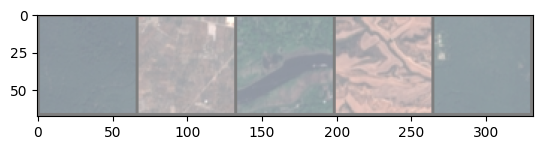

Predicted:  Forest  PermanentCrop  River  PermanentCrop  Forest 
Actual:     Forest  PermanentCrop  River  HerbaceousVegetation  Forest 


In [45]:
import random
classes = dataset.classes

def imshow(img):
    img = img.cpu() / 2 + 0.5  # Move the image to CPU and unnormalize
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()

# Move the model to the GPU (if using CUDA)
model = model.cuda()

# Get a batch of images and labels from the test loader
images, labels = next(iter(test_loader))

# Move the images to the GPU (if using CUDA)
images = images.cuda()

# Pass the images through the model
outputs = model(images)

# Get the predicted class indices
_, predicted = torch.max(outputs, 1)

# Move the images to the CPU for displaying
images_cpu = images.cpu()

num_images_to_display = 5
random_indices = random.sample(range(len(images_cpu)), num_images_to_display)

# Select random images and corresponding labels
random_images = images_cpu[random_indices]
random_predicted_labels = predicted[random_indices]
random_actual_labels = labels[random_indices]

# Show the randomly selected images
imshow(torchvision.utils.make_grid(random_images))

# Print the predicted classes for the first 4 images
print('Predicted: ', ' '.join('%5s ' % classes[random_predicted_labels[j]] for j in range(num_images_to_display)))

# Print the actual classes for the first 5 images
print('Actual:    ', ' '.join('%5s ' % classes[random_actual_labels[j]] for j in range(num_images_to_display)))

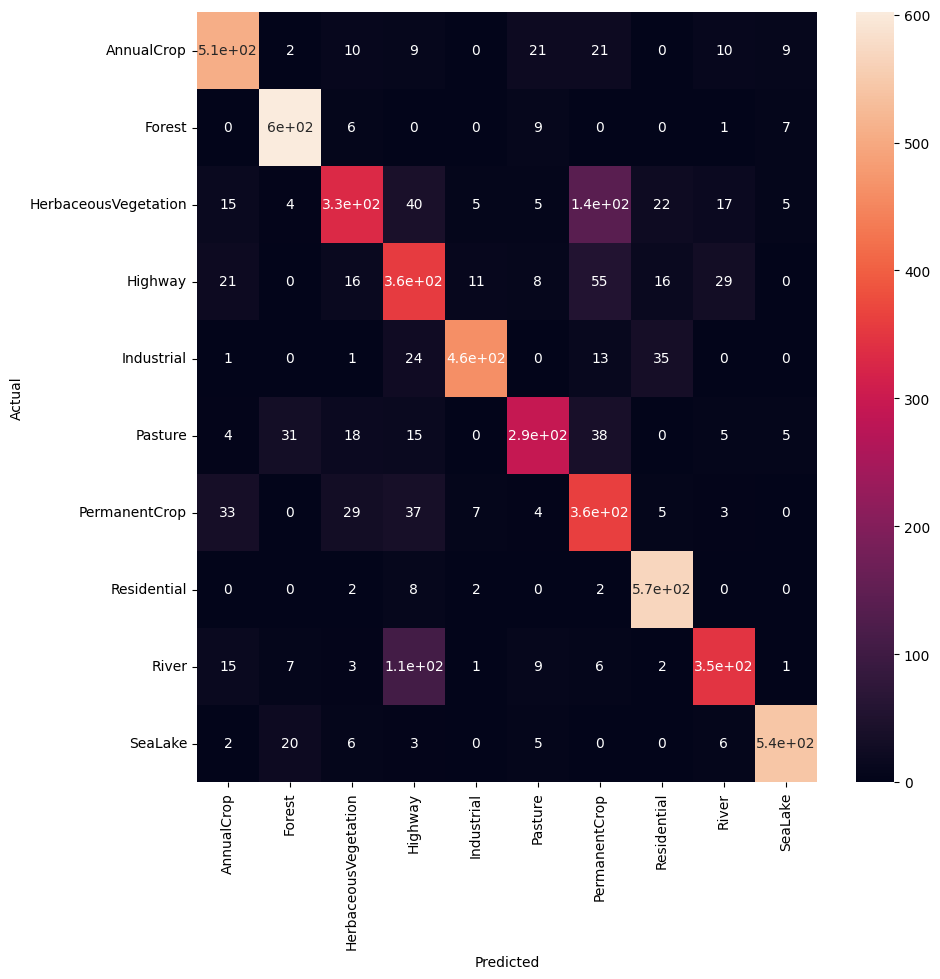

In [22]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [23]:
cm

array([[507,   2,  10,   9,   0,  21,  21,   0,  10,   9],
       [  0, 602,   6,   0,   0,   9,   0,   0,   1,   7],
       [ 15,   4, 331,  40,   5,   5, 141,  22,  17,   5],
       [ 21,   0,  16, 356,  11,   8,  55,  16,  29,   0],
       [  1,   0,   1,  24, 461,   0,  13,  35,   0,   0],
       [  4,  31,  18,  15,   0, 292,  38,   0,   5,   5],
       [ 33,   0,  29,  37,   7,   4, 362,   5,   3,   0],
       [  0,   0,   2,   8,   2,   0,   2, 568,   0,   0],
       [ 15,   7,   3, 107,   1,   9,   6,   2, 348,   1],
       [  2,  20,   6,   3,   0,   5,   0,   0,   6, 543]], dtype=int64)

In [24]:
classes

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [36]:
from collections import Counter

# Assuming all_labels contains the true labels for the entire test set
all_labels = []

# Iterate through the test dataset to collect all true labels
for _, labels in train_loader:
    all_labels.extend(labels.tolist())

# Count the occurrences of each label
label_counts = Counter(all_labels)

# Print the counts for each class
for class_idx, count in label_counts.items():
    print(f"Class {classes[class_idx]}: {count} occurrences")


Class Pasture: 1592 occurrences
Class AnnualCrop: 2411 occurrences
Class Highway: 1988 occurrences
Class Residential: 2418 occurrences
Class Forest: 2375 occurrences
Class River: 2001 occurrences
Class HerbaceousVegetation: 2415 occurrences
Class Industrial: 1965 occurrences
Class PermanentCrop: 2020 occurrences
Class SeaLake: 2415 occurrences


In [31]:
type(all_labels)

list

In [33]:
len(all_preds)

5400

True label: HerbaceousVegetation, Predicted label: PermanentCrop


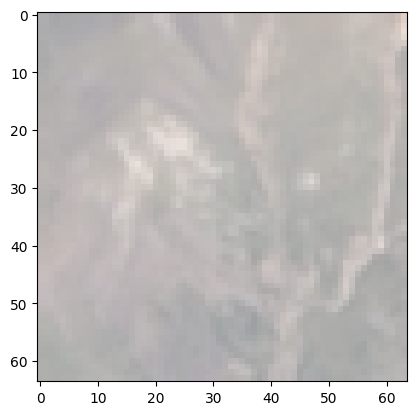

True label: HerbaceousVegetation, Predicted label: PermanentCrop


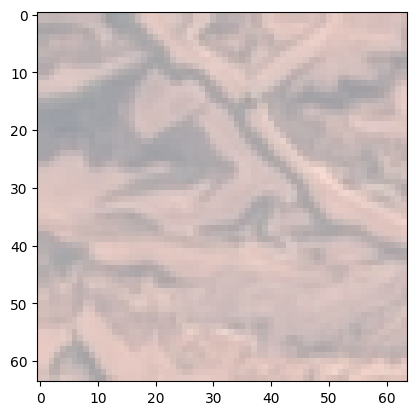

True label: HerbaceousVegetation, Predicted label: PermanentCrop


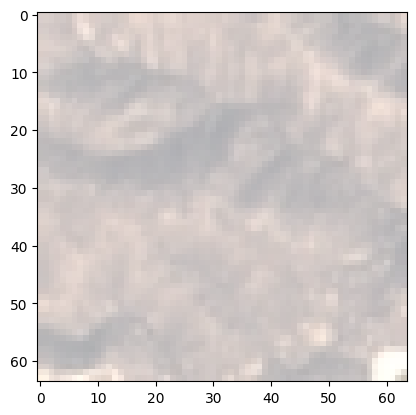

True label: Highway, Predicted label: River


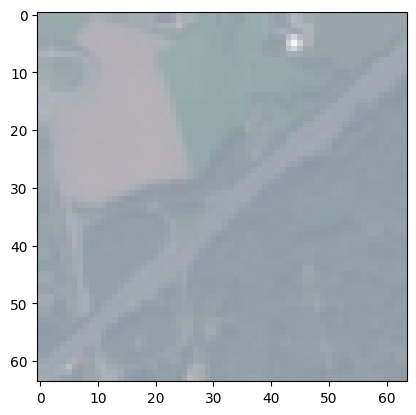

True label: River, Predicted label: AnnualCrop


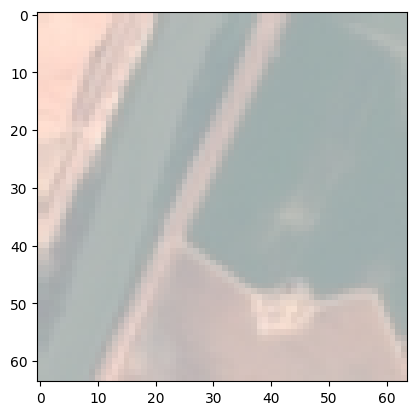

True label: HerbaceousVegetation, Predicted label: Highway


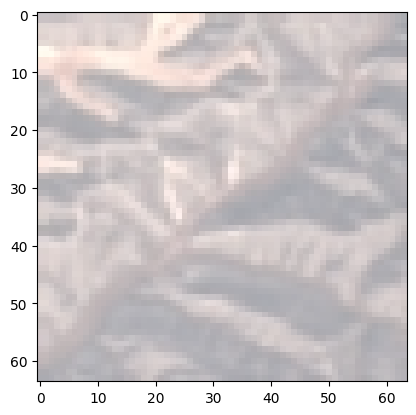

True label: PermanentCrop, Predicted label: Highway


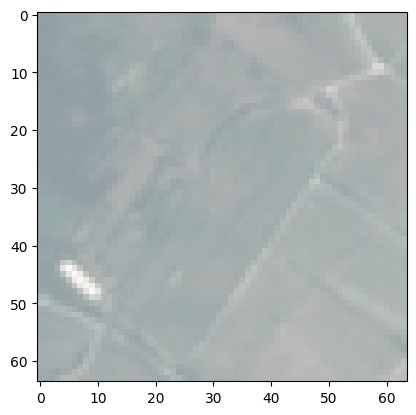

True label: Highway, Predicted label: Residential


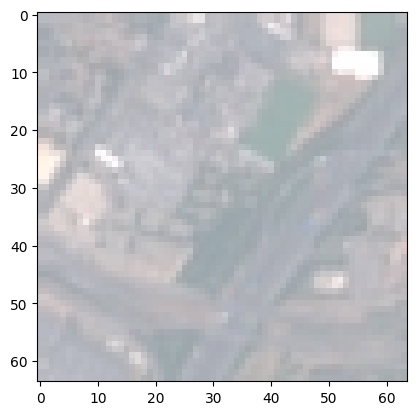

True label: River, Predicted label: Highway


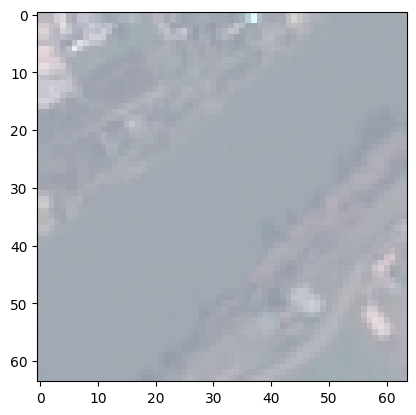

True label: PermanentCrop, Predicted label: AnnualCrop


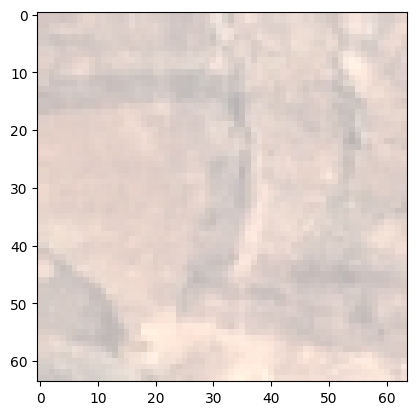

True label: River, Predicted label: Highway


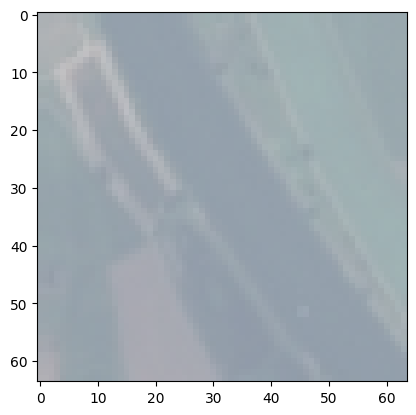

True label: HerbaceousVegetation, Predicted label: PermanentCrop


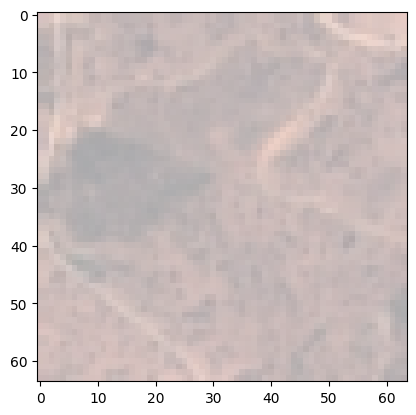

True label: River, Predicted label: Highway


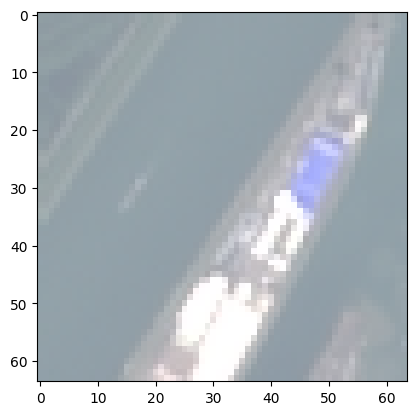

True label: HerbaceousVegetation, Predicted label: PermanentCrop


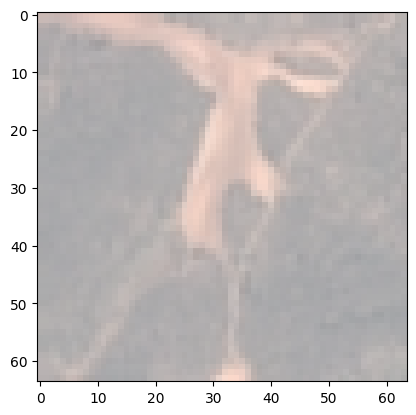

True label: HerbaceousVegetation, Predicted label: AnnualCrop


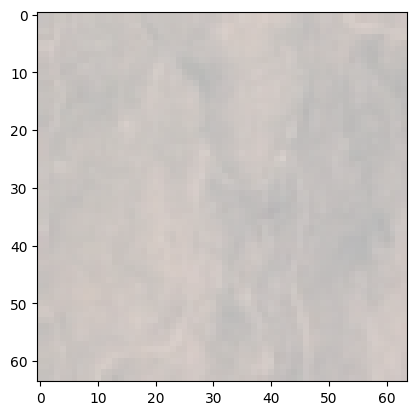

True label: Highway, Predicted label: PermanentCrop


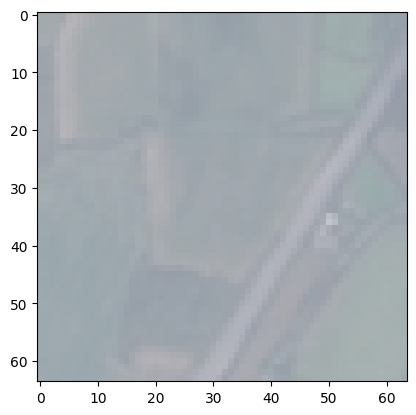

True label: River, Predicted label: Highway


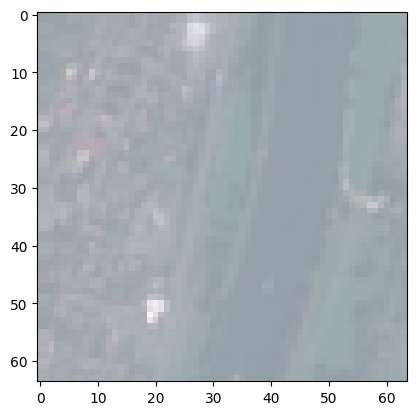

True label: HerbaceousVegetation, Predicted label: Highway


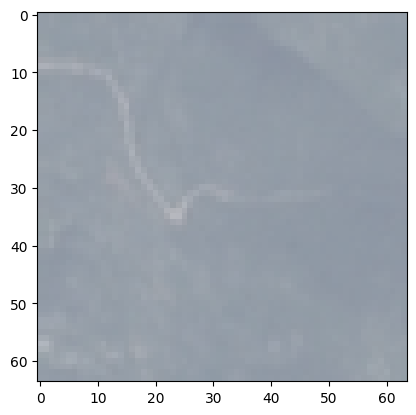

True label: HerbaceousVegetation, Predicted label: PermanentCrop


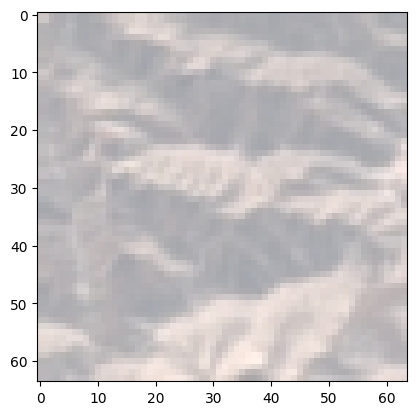

True label: HerbaceousVegetation, Predicted label: PermanentCrop


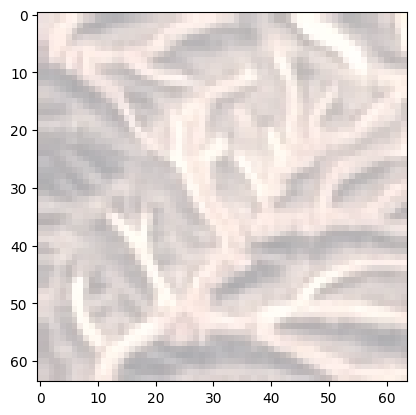

True label: PermanentCrop, Predicted label: Highway


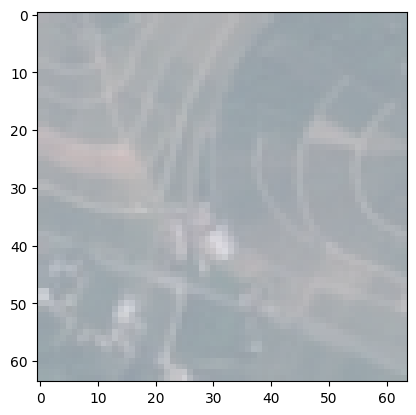

True label: Pasture, Predicted label: HerbaceousVegetation


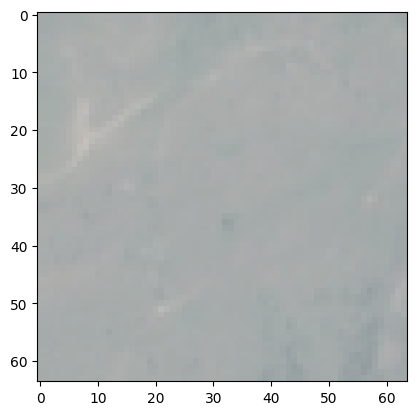

True label: Highway, Predicted label: River


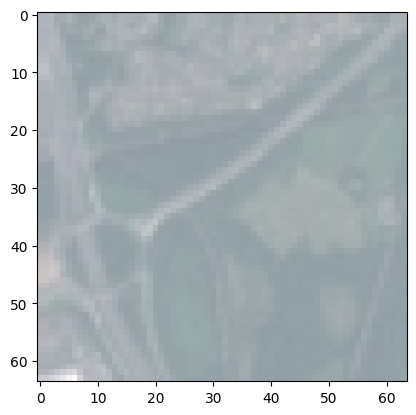

True label: River, Predicted label: Highway


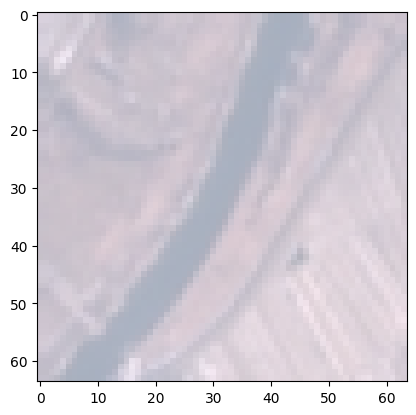

True label: AnnualCrop, Predicted label: River


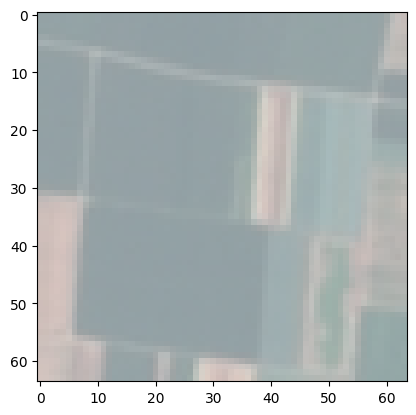

True label: Pasture, Predicted label: Forest


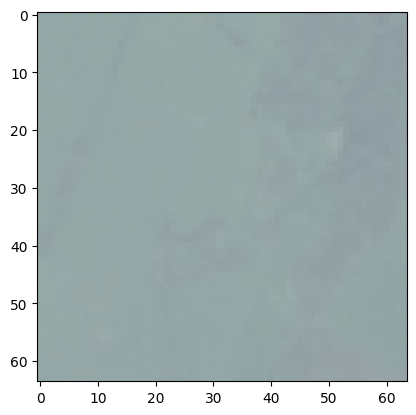

True label: HerbaceousVegetation, Predicted label: PermanentCrop


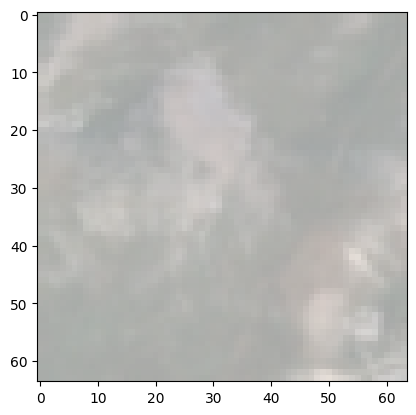

True label: AnnualCrop, Predicted label: PermanentCrop


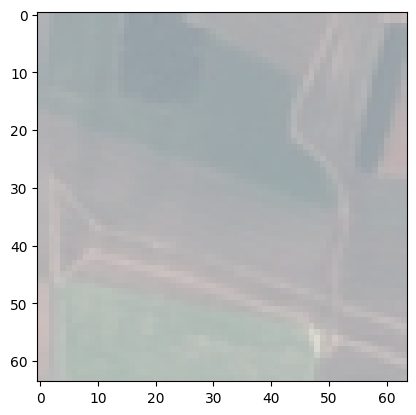

True label: Highway, Predicted label: AnnualCrop


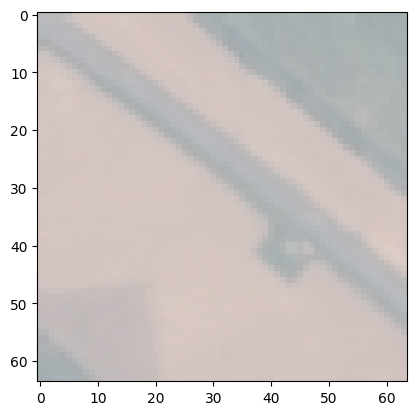

True label: PermanentCrop, Predicted label: AnnualCrop


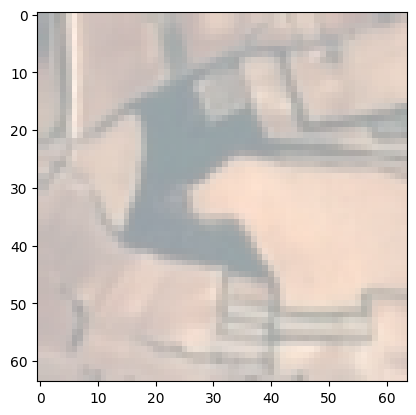

True label: AnnualCrop, Predicted label: PermanentCrop


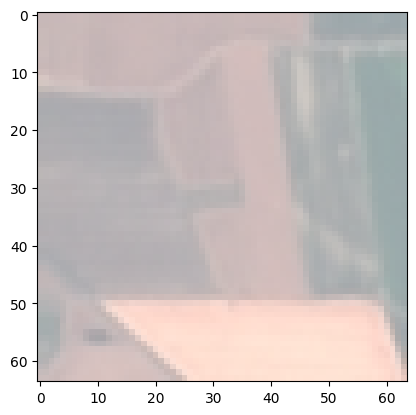

True label: Residential, Predicted label: PermanentCrop


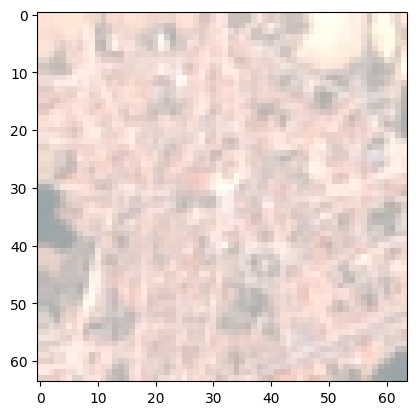

True label: River, Predicted label: Highway


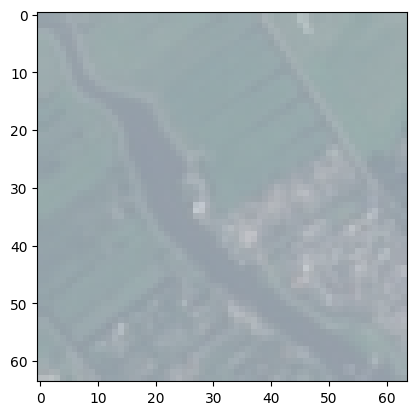

True label: River, Predicted label: Highway


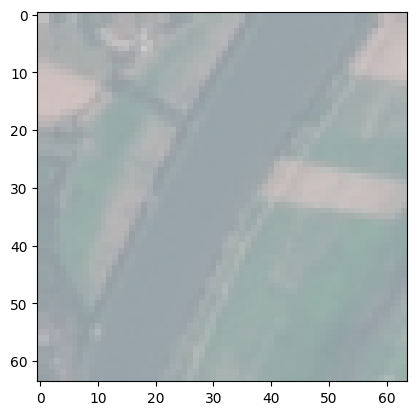

True label: River, Predicted label: Highway


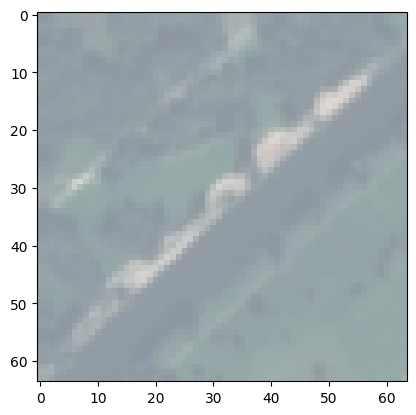

True label: PermanentCrop, Predicted label: Highway


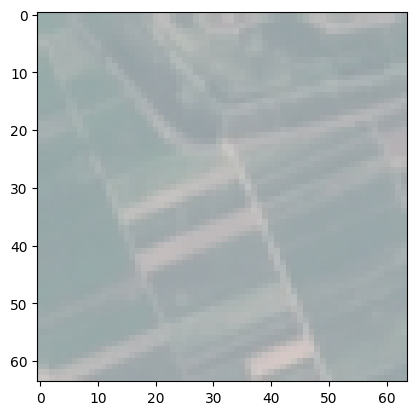

True label: HerbaceousVegetation, Predicted label: Residential


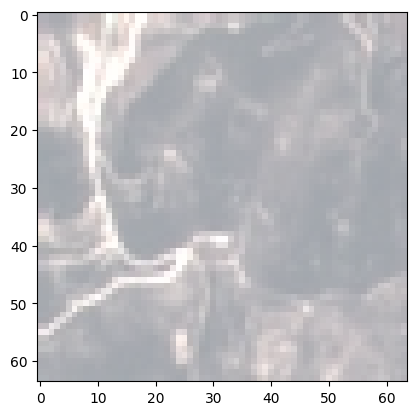

True label: River, Predicted label: Forest


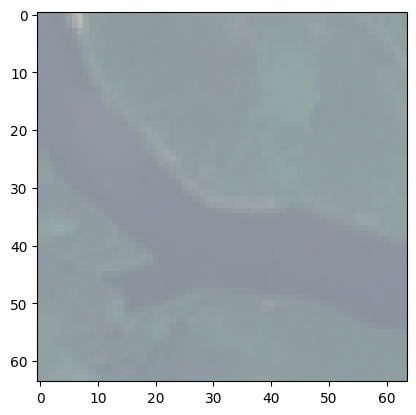

True label: Highway, Predicted label: PermanentCrop


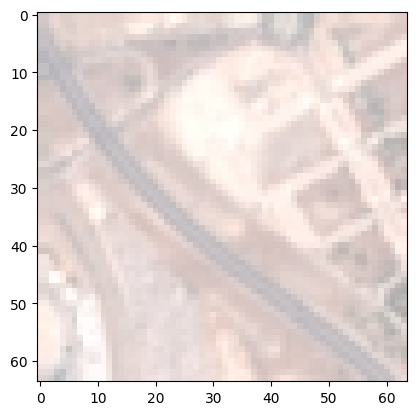

True label: River, Predicted label: Highway


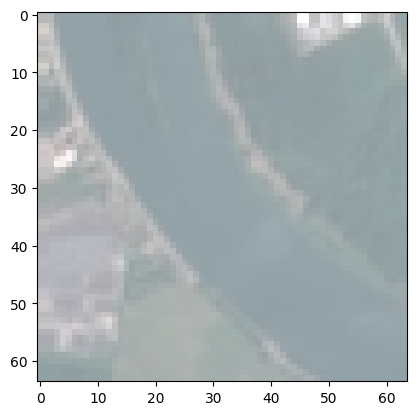

True label: AnnualCrop, Predicted label: HerbaceousVegetation


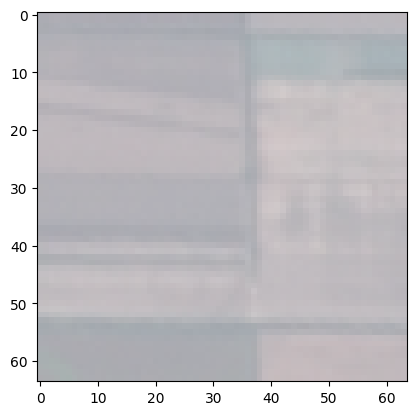

True label: Pasture, Predicted label: Forest


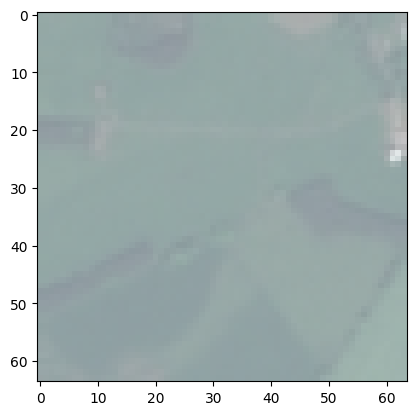

True label: River, Predicted label: Highway


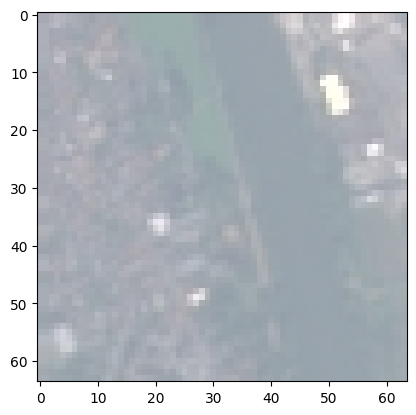

True label: PermanentCrop, Predicted label: AnnualCrop


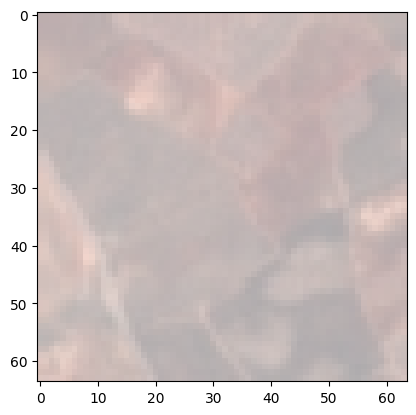

True label: Highway, Predicted label: HerbaceousVegetation


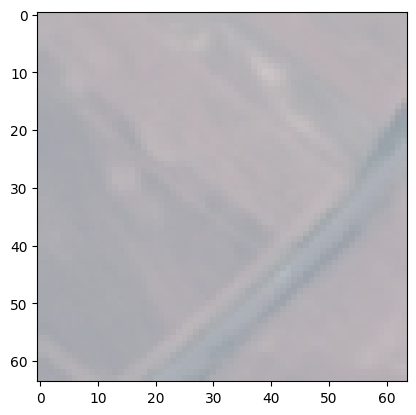

True label: PermanentCrop, Predicted label: AnnualCrop


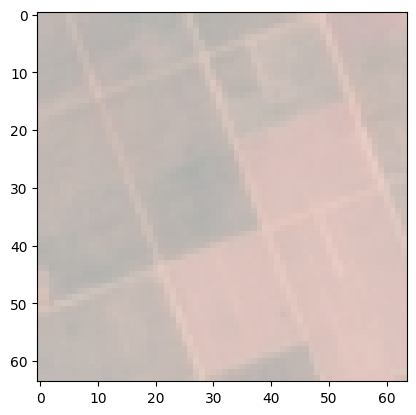

True label: PermanentCrop, Predicted label: Industrial


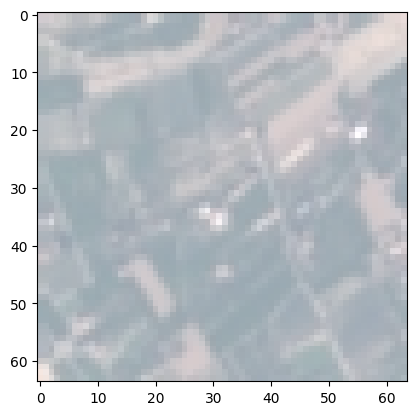

True label: HerbaceousVegetation, Predicted label: PermanentCrop


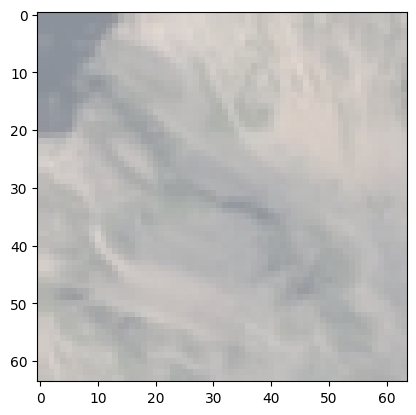

True label: AnnualCrop, Predicted label: Pasture


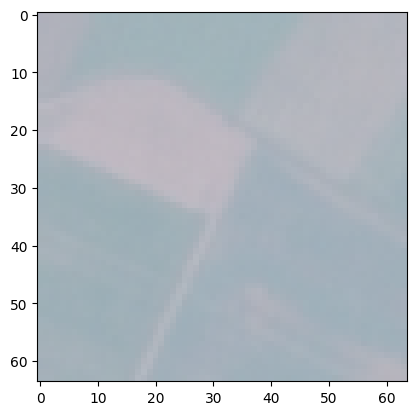

True label: HerbaceousVegetation, Predicted label: PermanentCrop


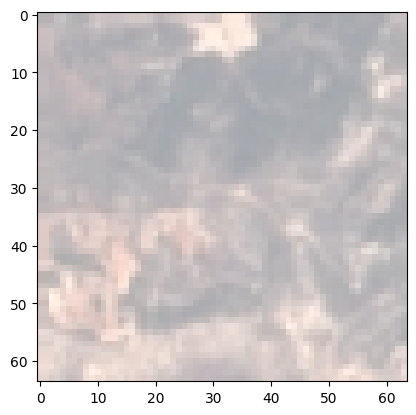

True label: HerbaceousVegetation, Predicted label: PermanentCrop


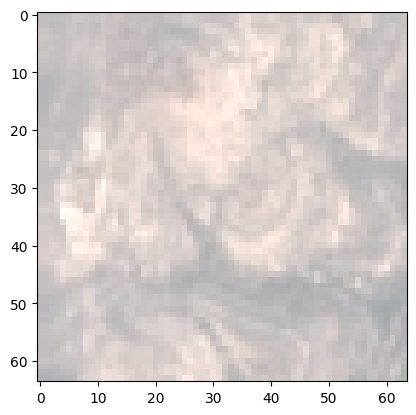

True label: River, Predicted label: Highway


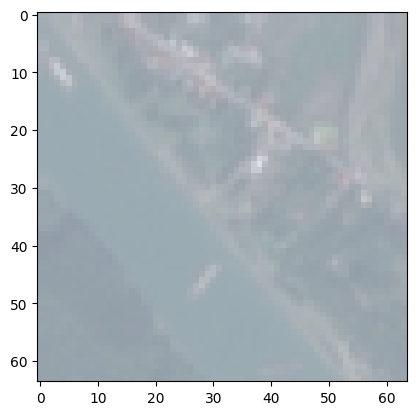

True label: Highway, Predicted label: PermanentCrop


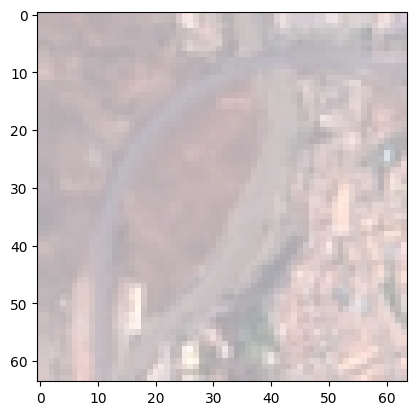

True label: River, Predicted label: Highway


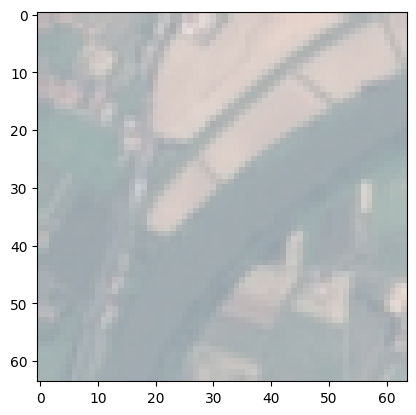

True label: River, Predicted label: Highway


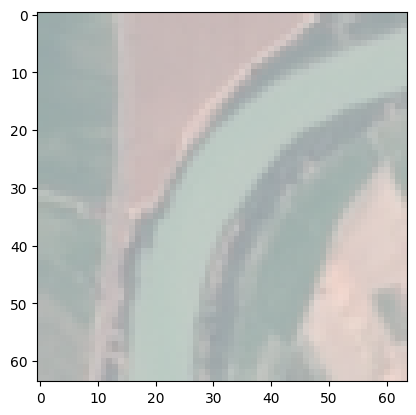

True label: HerbaceousVegetation, Predicted label: Highway


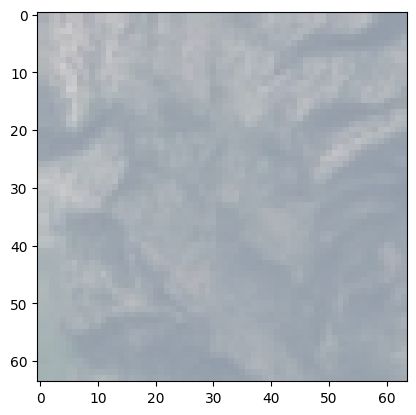

True label: River, Predicted label: Highway


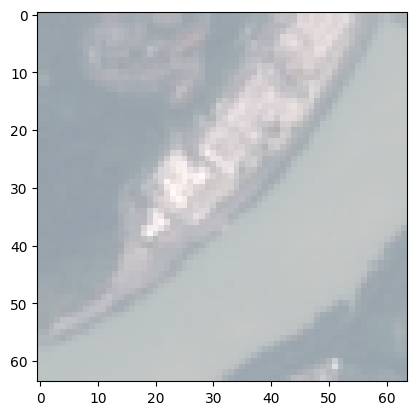

True label: HerbaceousVegetation, Predicted label: PermanentCrop


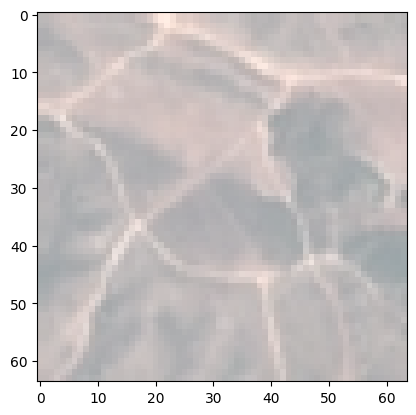

True label: AnnualCrop, Predicted label: PermanentCrop


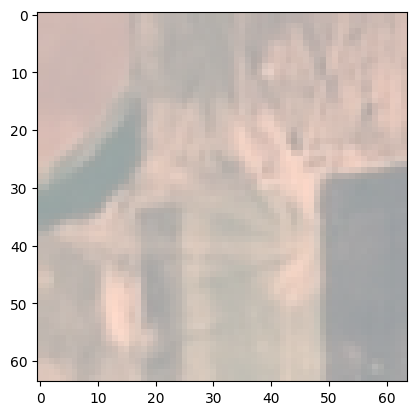

True label: River, Predicted label: Pasture


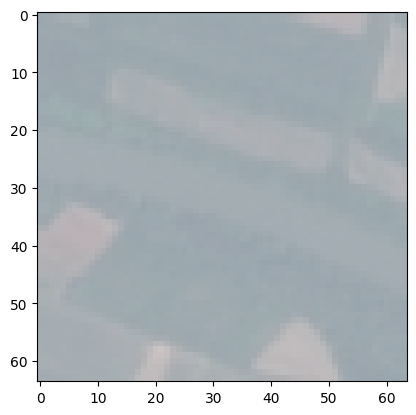

True label: HerbaceousVegetation, Predicted label: River


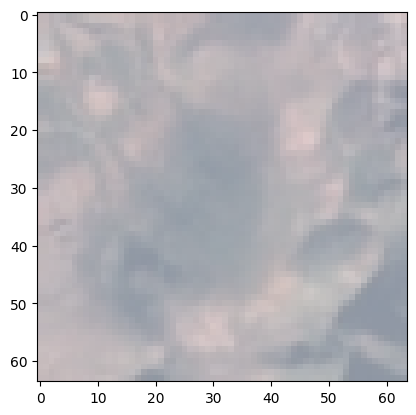

True label: Pasture, Predicted label: River


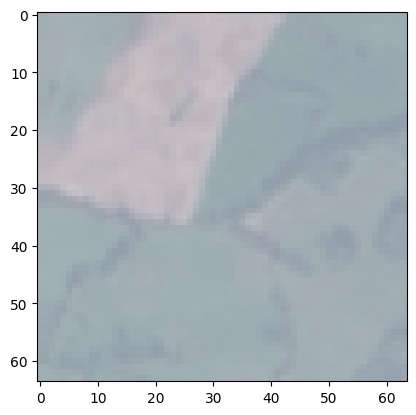

True label: Pasture, Predicted label: PermanentCrop


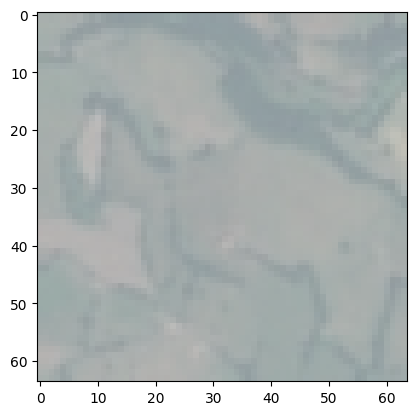

True label: HerbaceousVegetation, Predicted label: PermanentCrop


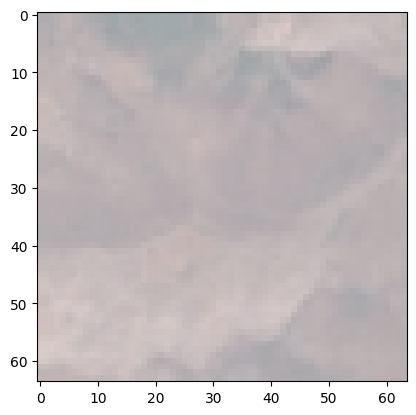

True label: River, Predicted label: Highway


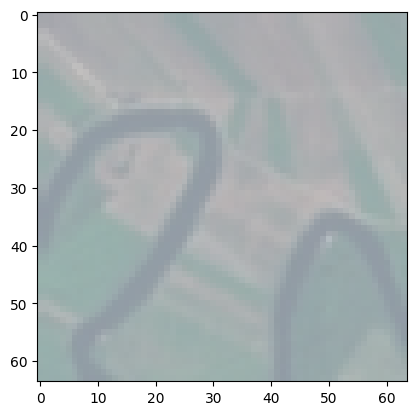

True label: HerbaceousVegetation, Predicted label: PermanentCrop


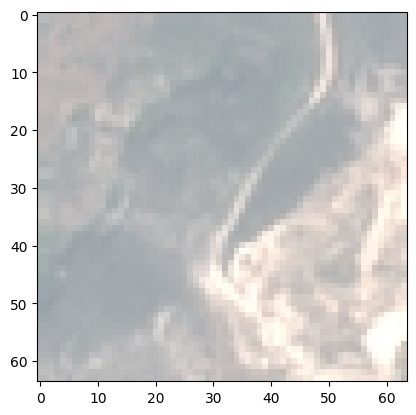

True label: PermanentCrop, Predicted label: AnnualCrop


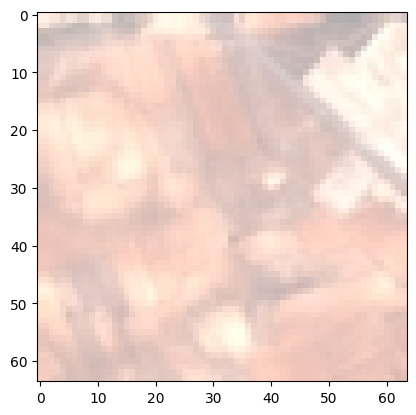

True label: HerbaceousVegetation, Predicted label: PermanentCrop


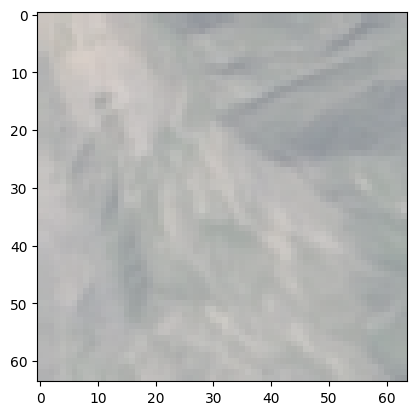

True label: AnnualCrop, Predicted label: Highway


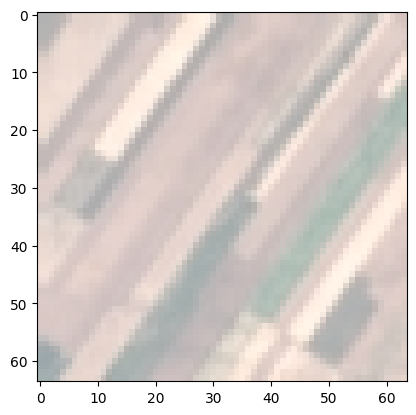

True label: HerbaceousVegetation, Predicted label: Residential


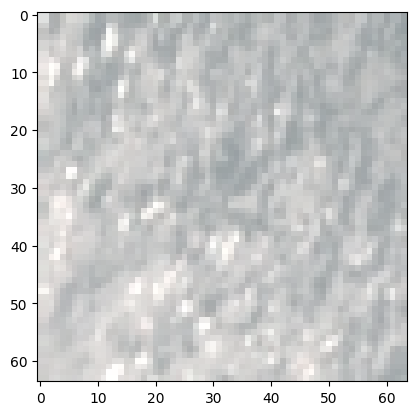

True label: Industrial, Predicted label: Residential


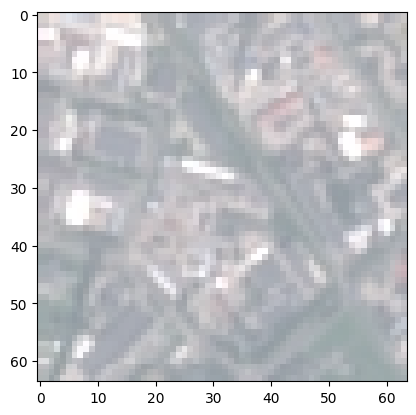

True label: Highway, Predicted label: Residential


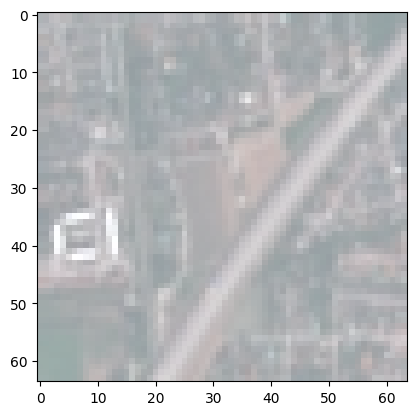

True label: AnnualCrop, Predicted label: HerbaceousVegetation


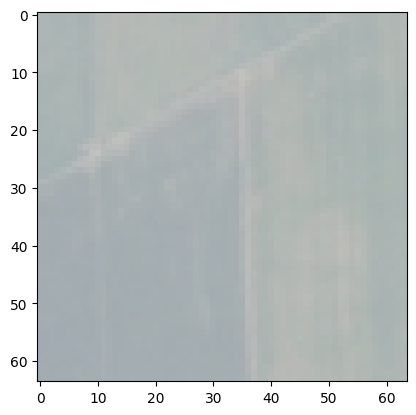

True label: Highway, Predicted label: PermanentCrop


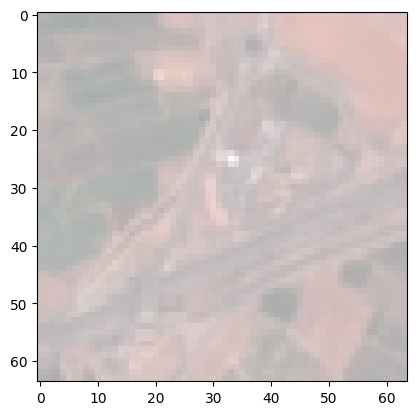

True label: River, Predicted label: PermanentCrop


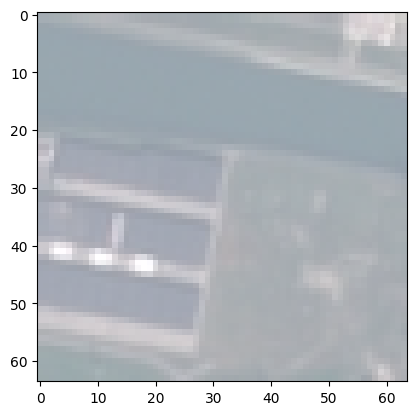

True label: PermanentCrop, Predicted label: River


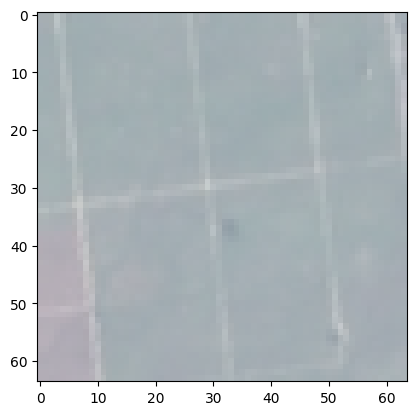

True label: AnnualCrop, Predicted label: PermanentCrop


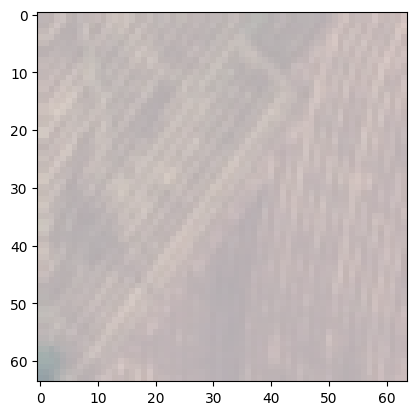

True label: HerbaceousVegetation, Predicted label: Highway


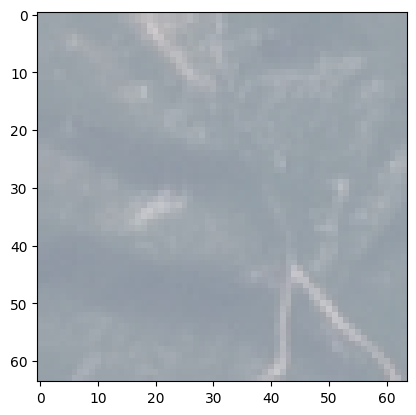

True label: PermanentCrop, Predicted label: AnnualCrop


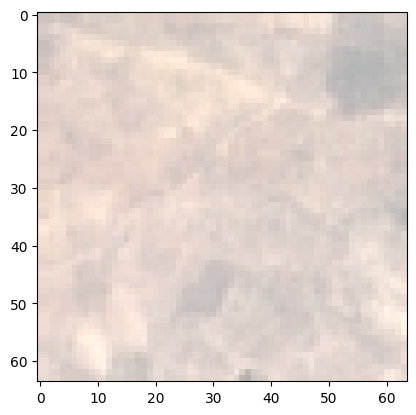

True label: HerbaceousVegetation, Predicted label: Highway


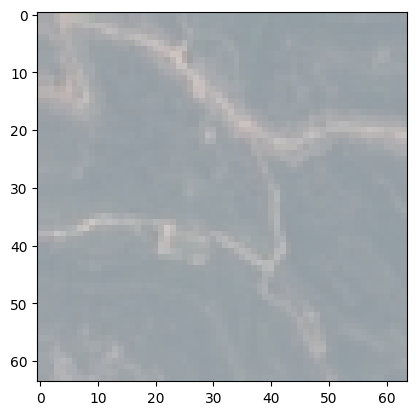

True label: PermanentCrop, Predicted label: Highway


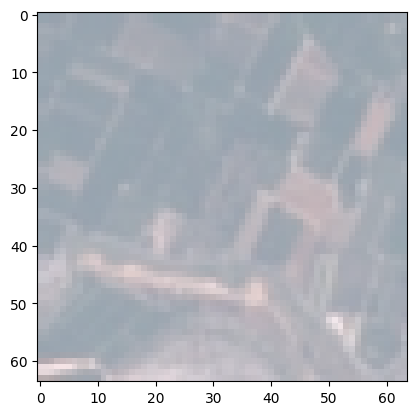

True label: SeaLake, Predicted label: Forest


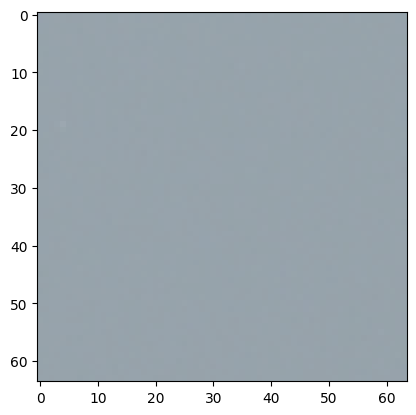

True label: HerbaceousVegetation, Predicted label: Highway


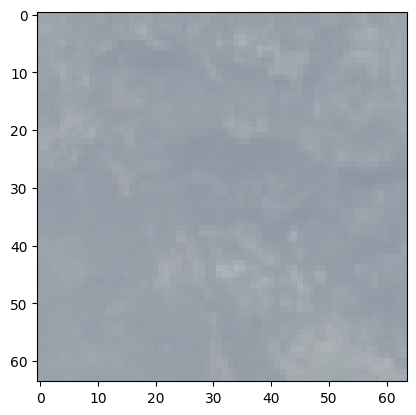

True label: Highway, Predicted label: Industrial


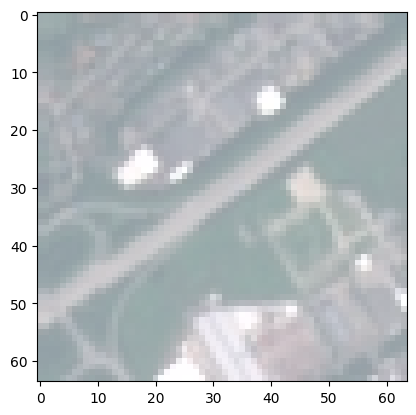

True label: Residential, Predicted label: HerbaceousVegetation


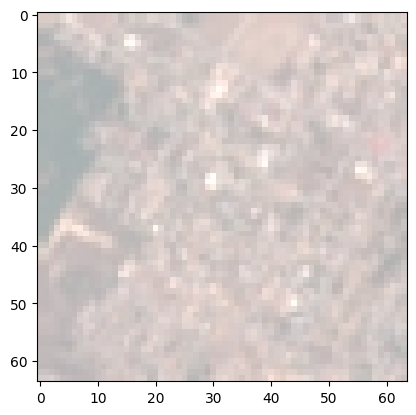

True label: River, Predicted label: Highway


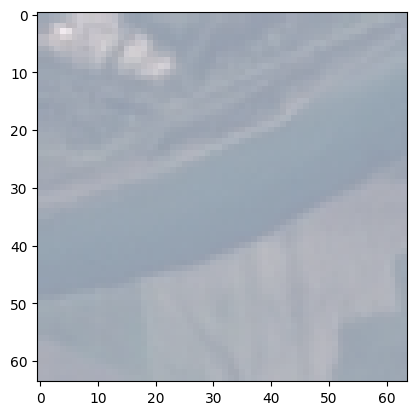

True label: River, Predicted label: Highway


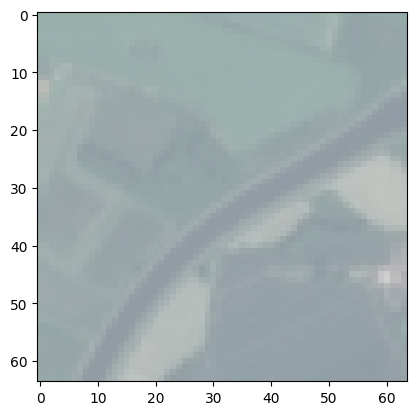

True label: Highway, Predicted label: PermanentCrop


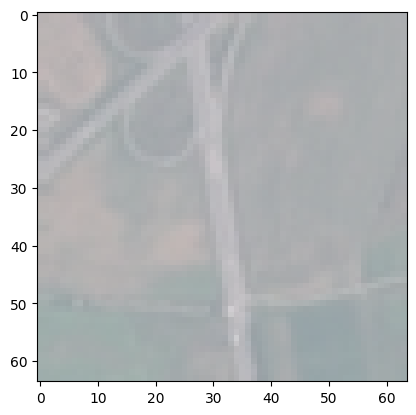

True label: Forest, Predicted label: HerbaceousVegetation


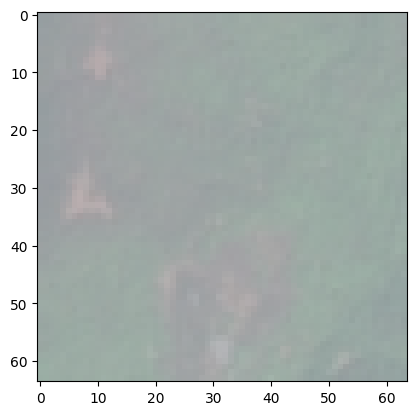

True label: Pasture, Predicted label: Forest


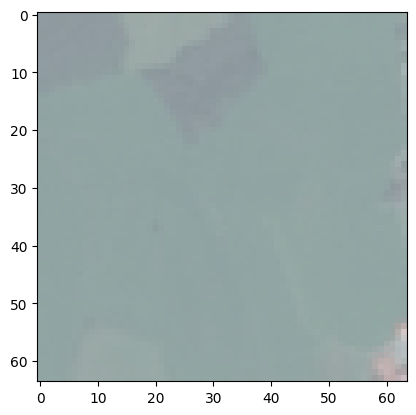

True label: HerbaceousVegetation, Predicted label: PermanentCrop


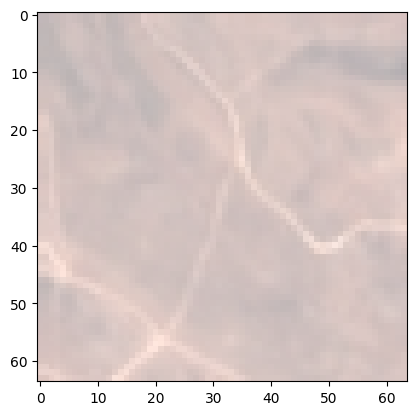

True label: HerbaceousVegetation, Predicted label: River


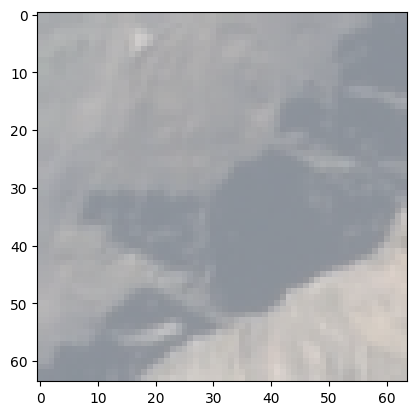

True label: Pasture, Predicted label: Forest


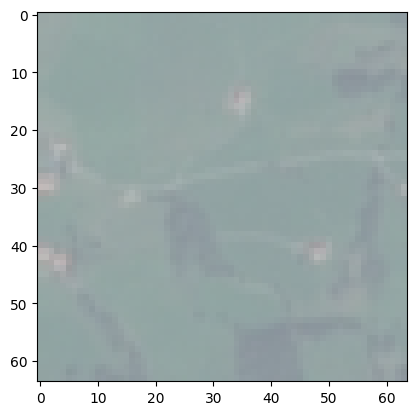

True label: HerbaceousVegetation, Predicted label: PermanentCrop


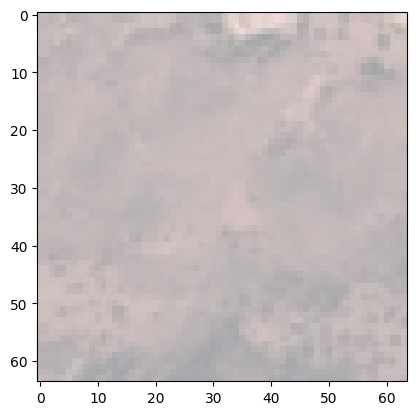

True label: Highway, Predicted label: HerbaceousVegetation


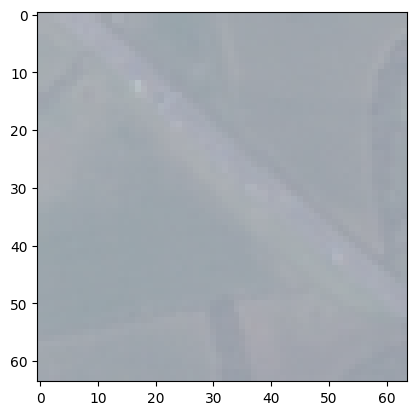

True label: River, Predicted label: Highway


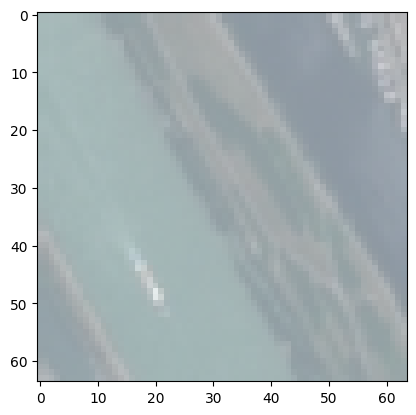

True label: Industrial, Predicted label: Residential


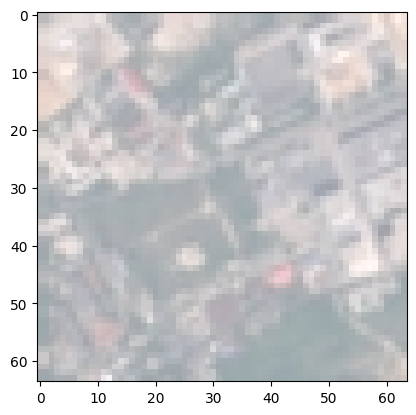

True label: Industrial, Predicted label: Highway


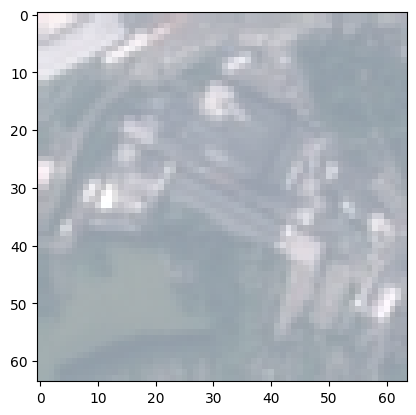

True label: Forest, Predicted label: HerbaceousVegetation


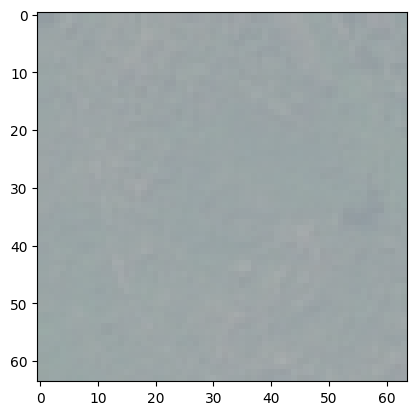

True label: Residential, Predicted label: Highway


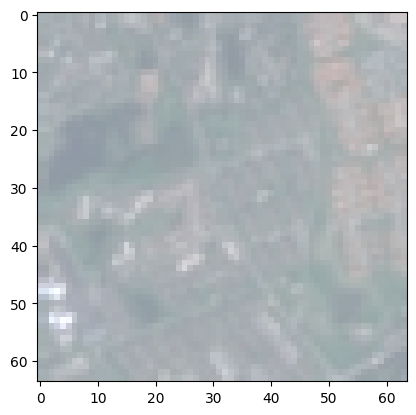

True label: HerbaceousVegetation, Predicted label: Highway


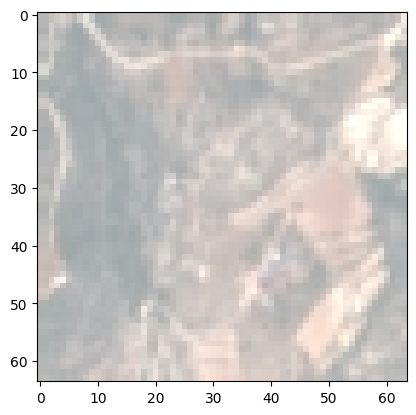

True label: HerbaceousVegetation, Predicted label: PermanentCrop


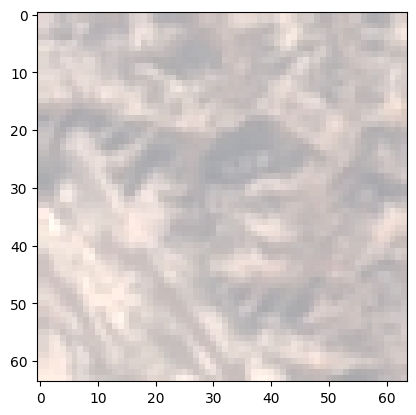

True label: River, Predicted label: Highway


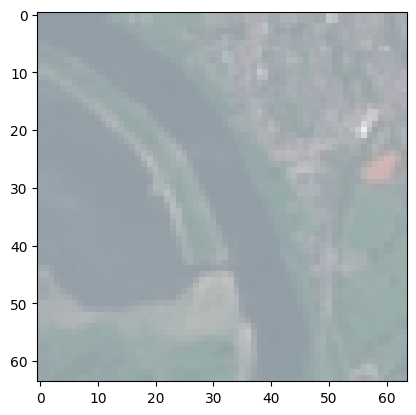

True label: River, Predicted label: HerbaceousVegetation


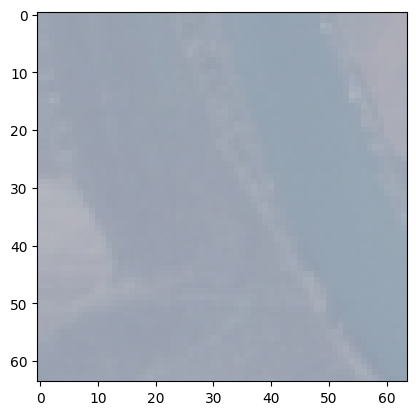

True label: HerbaceousVegetation, Predicted label: PermanentCrop


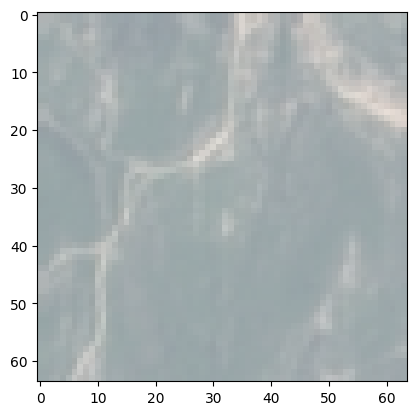

True label: Highway, Predicted label: AnnualCrop


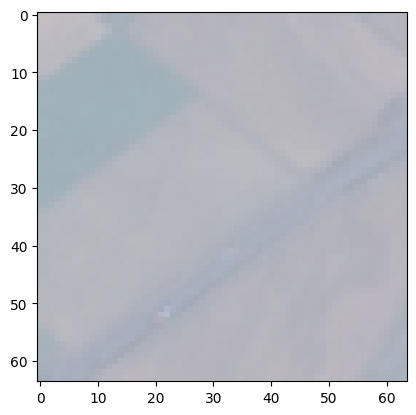

True label: Highway, Predicted label: River


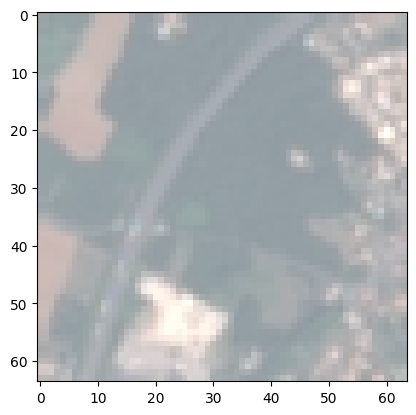

True label: PermanentCrop, Predicted label: Residential


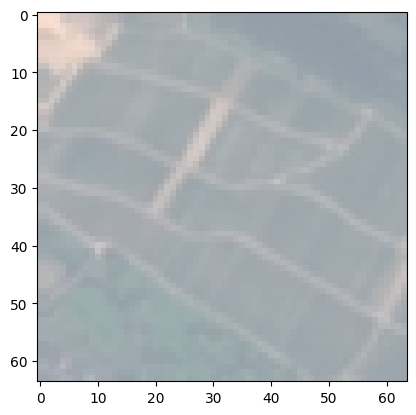

True label: Pasture, Predicted label: River


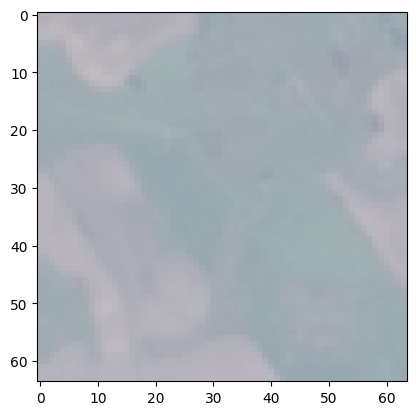

True label: PermanentCrop, Predicted label: AnnualCrop


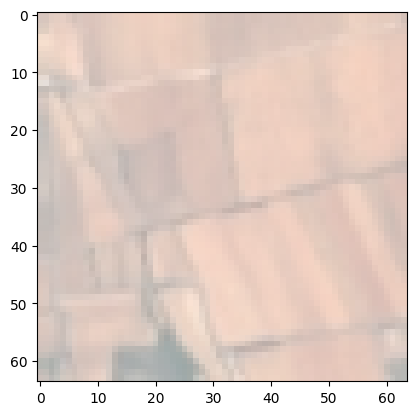

True label: HerbaceousVegetation, Predicted label: Highway


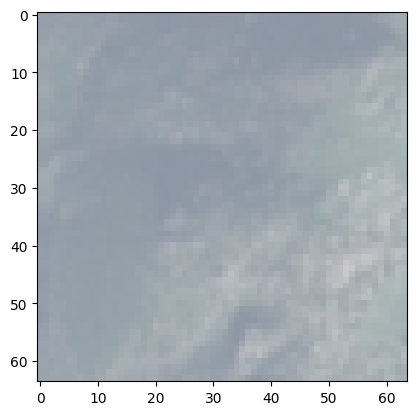

True label: PermanentCrop, Predicted label: HerbaceousVegetation


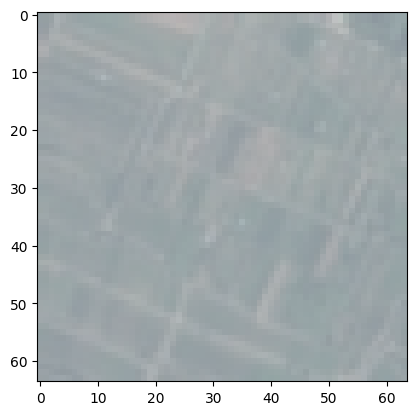

True label: Pasture, Predicted label: Forest


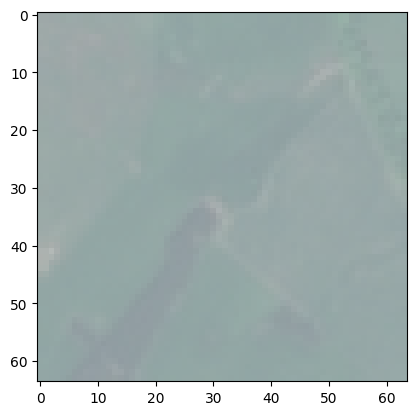

True label: River, Predicted label: PermanentCrop


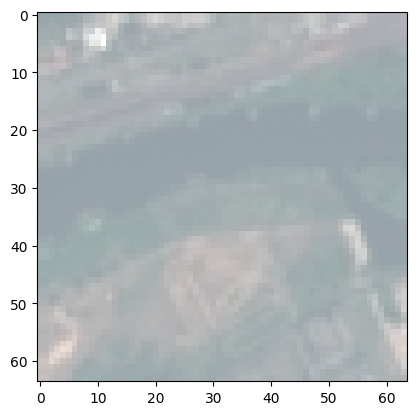

True label: Highway, Predicted label: HerbaceousVegetation


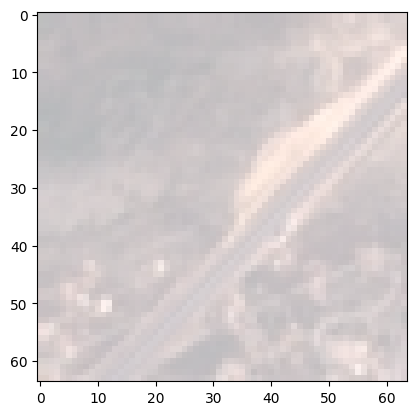

True label: Industrial, Predicted label: Highway


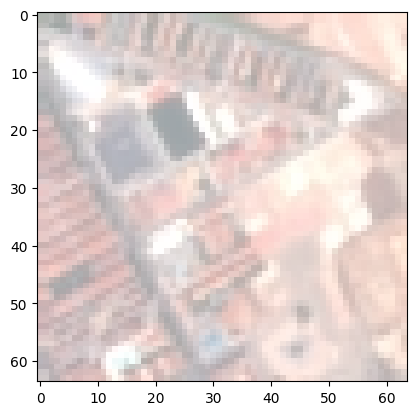

True label: HerbaceousVegetation, Predicted label: PermanentCrop


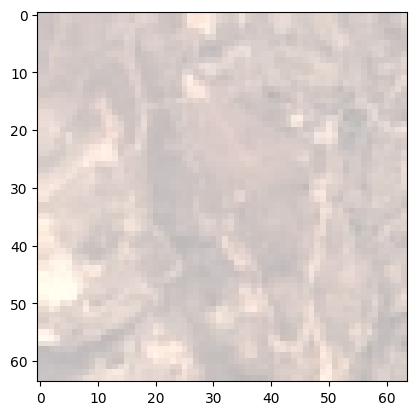

True label: PermanentCrop, Predicted label: HerbaceousVegetation


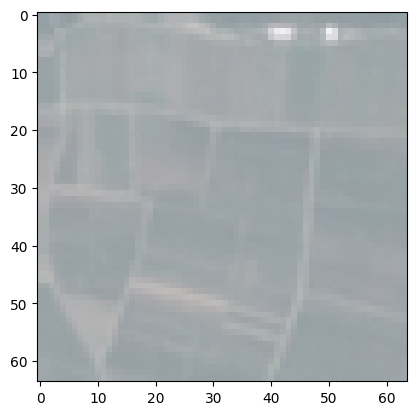

True label: AnnualCrop, Predicted label: HerbaceousVegetation


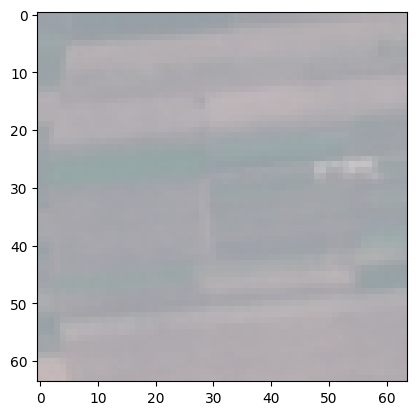

True label: PermanentCrop, Predicted label: Highway


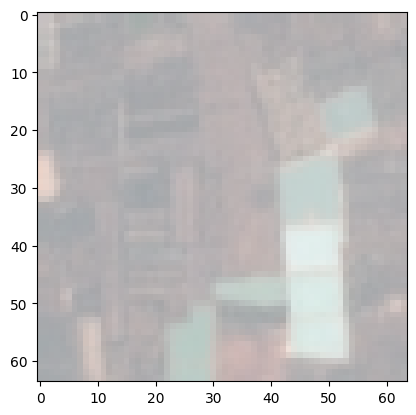

True label: AnnualCrop, Predicted label: SeaLake


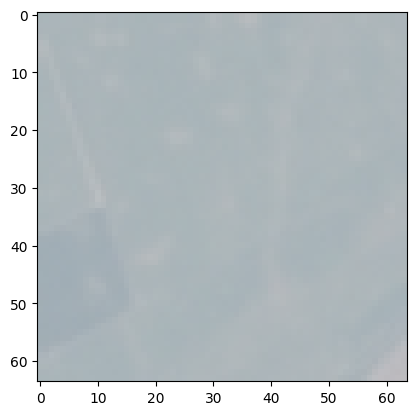

True label: Highway, Predicted label: PermanentCrop


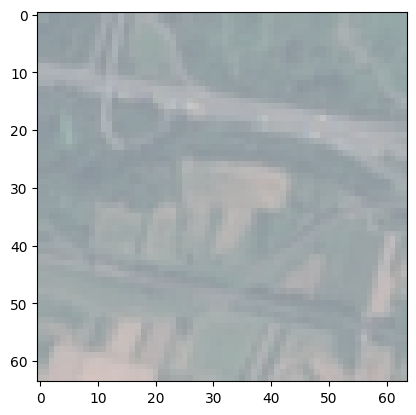

True label: PermanentCrop, Predicted label: AnnualCrop


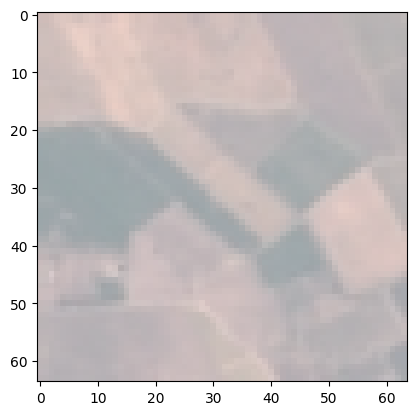

True label: AnnualCrop, Predicted label: SeaLake


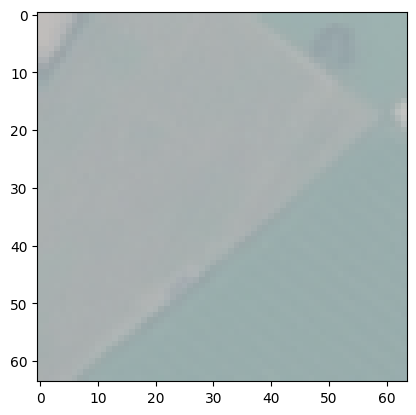

True label: HerbaceousVegetation, Predicted label: PermanentCrop


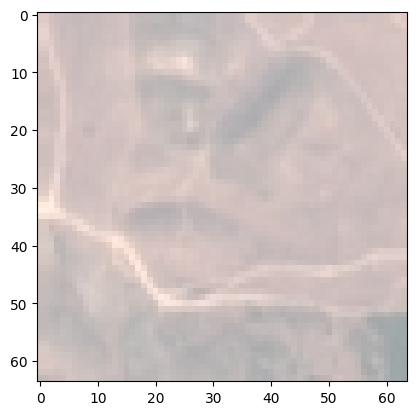

True label: Highway, Predicted label: AnnualCrop


KeyboardInterrupt: 

In [35]:
misclassified_images = []
misclassified_labels = []
true_labels = []

# Iterate through the test dataset
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    # Find the misclassified indices
    misclassified_idx = (predicted != labels).nonzero(as_tuple=False).squeeze()

    # Check if there are any misclassified examples
    if misclassified_idx.dim() == 0:
        continue

    # If misclassified_idx is a 1D tensor, make it a list for iteration
    if misclassified_idx.dim() == 1:
        misclassified_idx = misclassified_idx.tolist()

    # Store the misclassified images and labels
    for idx in misclassified_idx:
        misclassified_images.append(images[idx].cpu())
        misclassified_labels.append(predicted[idx].cpu())
        true_labels.append(labels[idx].cpu())

# Analyze the misclassified images
for i in range(len(misclassified_images)):
    print(f"True label: {classes[true_labels[i]]}, Predicted label: {classes[misclassified_labels[i]]}")
    imshow(misclassified_images[i])


### Implementing advanced CNN:

In [ ]:
# Step 2: Load Dataset
data_transform = transforms.Compose([
    transforms.RandomResizedCrop(64),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = ImageFolder(root='STA380/STA380-master/data/EuroSAT_RGB', transform=data_transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [46]:
# Step 3: Define the CNN Model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 11) # 11 classes
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [47]:
# Step 4: Train the Model
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

for epoch in range(10): # 10 epochs
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

In [48]:
# Step 5: Evaluate the Model
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu())
        all_labels.extend(labels.cpu())

accuracy = correct / total
print(f'Overall Test-Set Accuracy: {accuracy * 100}%')

Overall Test-Set Accuracy: 81.9074074074074%


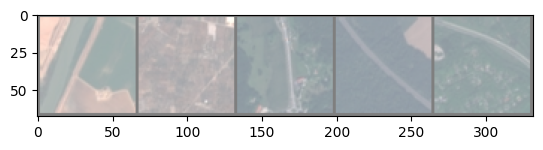

Predicted:  AnnualCrop  PermanentCrop  Highway  Highway  Highway 
Actual:     River  PermanentCrop  Highway  Highway  Highway 


In [50]:
classes = dataset.classes

def imshow(img):
    img = img.cpu() / 2 + 0.5  # Move the image to CPU and unnormalize
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()

# Move the model to the GPU (if using CUDA)
model = model.cuda()

# Get a batch of images and labels from the test loader
images, labels = next(iter(test_loader))

# Move the images to the GPU (if using CUDA)
images = images.cuda()

# Pass the images through the model
outputs = model(images)

# Get the predicted class indices
_, predicted = torch.max(outputs, 1)

# Move the images to the CPU for displaying
images_cpu = images.cpu()

num_images_to_display = 5
random_indices = random.sample(range(len(images_cpu)), num_images_to_display)

# Select random images and corresponding labels
random_images = images_cpu[random_indices]
random_predicted_labels = predicted[random_indices]
random_actual_labels = labels[random_indices]

# Show the randomly selected images
imshow(torchvision.utils.make_grid(random_images))

# Print the predicted classes for the first 4 images
print('Predicted: ', ' '.join('%5s ' % classes[random_predicted_labels[j]] for j in range(num_images_to_display)))

# Print the actual classes for the first 5 images
print('Actual:    ', ' '.join('%5s ' % classes[random_actual_labels[j]] for j in range(num_images_to_display)))

#### ResNet18

In [5]:
# Step 2: Load Dataset
data_transform = transforms.Compose([
    transforms.RandomResizedCrop(64),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = ImageFolder(root='STA380/STA380-master/data/EuroSAT_RGB', transform=data_transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [6]:
from torchvision import models

In [7]:
# Step 3: Define the CNN Model (ResNet-18)
model = models.resnet18(weights = None)
model.fc = nn.Linear(model.fc.in_features, 11) # 11 classes
# Move the model to the GPU (if using CUDA)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [8]:
# Step 4: Train the Model

num_epochs = 20

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

for epoch in range(num_epochs): # 20 epochs
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader, 0):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99: # Print every 100 mini-batches
            print(f'Epoch {epoch + 1}, Mini-batch {i + 1}, Loss: {running_loss / 100}')
            running_loss = 0.0


Epoch 1, Mini-batch 100, Loss: 1.373726725578308
Epoch 1, Mini-batch 200, Loss: 1.0918303632736206
Epoch 1, Mini-batch 300, Loss: 0.9530681675672531
Epoch 2, Mini-batch 100, Loss: 0.8960142064094544
Epoch 2, Mini-batch 200, Loss: 0.8762201434373855
Epoch 2, Mini-batch 300, Loss: 0.8132086664438247
Epoch 3, Mini-batch 100, Loss: 0.75115194439888
Epoch 3, Mini-batch 200, Loss: 0.7310359394550323
Epoch 3, Mini-batch 300, Loss: 0.6791975322365761
Epoch 4, Mini-batch 100, Loss: 0.6863639816641808
Epoch 4, Mini-batch 200, Loss: 0.6472729679942131
Epoch 4, Mini-batch 300, Loss: 0.62037563174963
Epoch 5, Mini-batch 100, Loss: 0.6056632214784622
Epoch 5, Mini-batch 200, Loss: 0.5643149477243423
Epoch 5, Mini-batch 300, Loss: 0.5689493206143379
Epoch 6, Mini-batch 100, Loss: 0.5268041458725929
Epoch 6, Mini-batch 200, Loss: 0.5338302376866341
Epoch 6, Mini-batch 300, Loss: 0.5326879632472992
Epoch 7, Mini-batch 100, Loss: 0.49968351915478704
Epoch 7, Mini-batch 200, Loss: 0.46253909945487975
Epo

In [9]:
# Step 5: Evaluate the Model
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu())
        all_labels.extend(labels.cpu())

accuracy = correct / total
print(f'Overall Test-Set Accuracy: {accuracy * 100}%')

Overall Test-Set Accuracy: 88.77777777777777%


In [11]:
import random

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


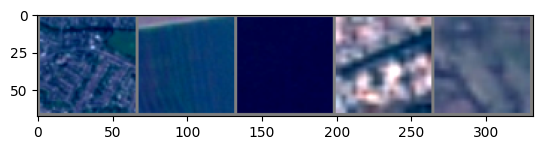

Predicted:  Residential  AnnualCrop  SeaLake  HerbaceousVegetation  HerbaceousVegetation 
Actual:     Residential  AnnualCrop  SeaLake  Residential  HerbaceousVegetation 


In [13]:
classes = dataset.classes

def imshow(img):
    img = img.cpu() / 2 + 0.5  # Move the image to CPU and unnormalize
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()

# Get a batch of images and labels from the test loader
images, labels = next(iter(test_loader))

# Move the images to the GPU (if using CUDA)
images = images.cuda()

# Pass the images through the model
outputs = model(images)

# Get the predicted class indices
_, predicted = torch.max(outputs, 1)

# Move the images to the CPU for displaying
images_cpu = images.cpu()

num_images_to_display = 5
random_indices = random.sample(range(len(images_cpu)), num_images_to_display)

# Select random images and corresponding labels
random_images = images_cpu[random_indices]
random_predicted_labels = predicted[random_indices]
random_actual_labels = labels[random_indices]

# Show the randomly selected images
imshow(torchvision.utils.make_grid(random_images))

# Print the predicted classes for the first 4 images
print('Predicted: ', ' '.join('%5s ' % classes[random_predicted_labels[j]] for j in range(num_images_to_display)))

# Print the actual classes for the first 5 images
print('Actual:    ', ' '.join('%5s ' % classes[random_actual_labels[j]] for j in range(num_images_to_display)))

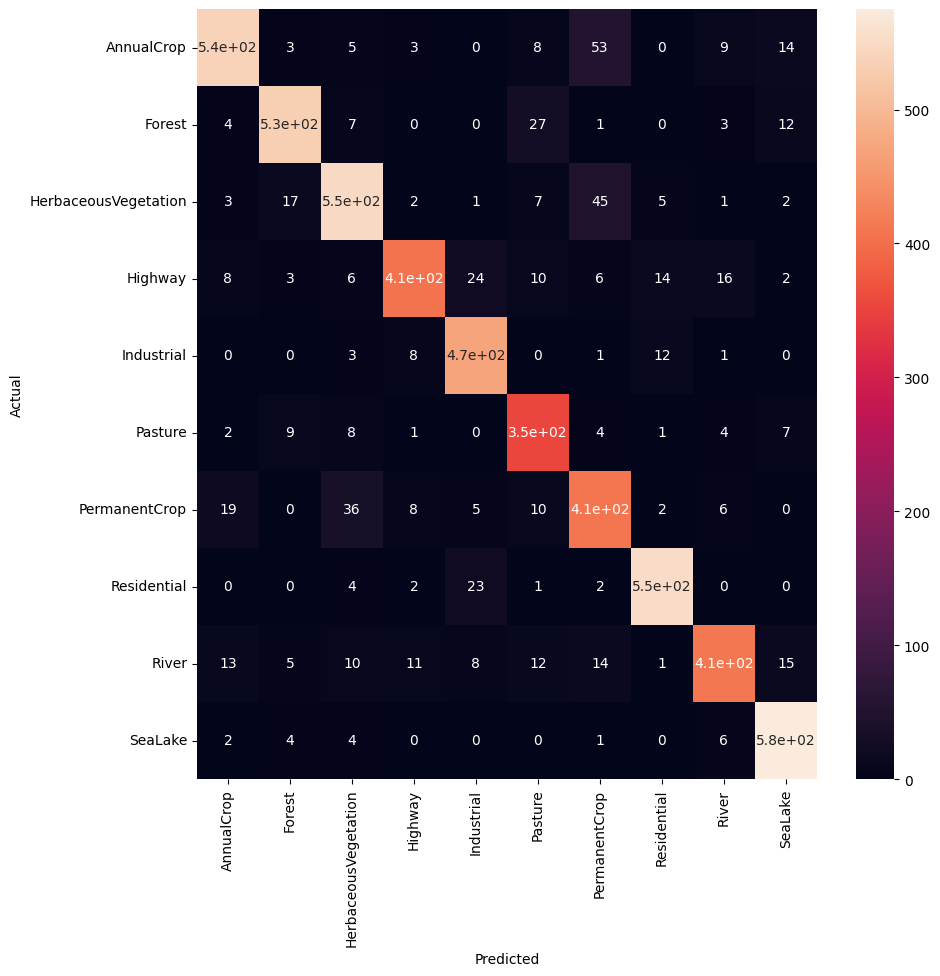

In [14]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()